
## **skin Disease Classification Using MobileNet CNN** 





---





Skin is the largest organ in the human body.skin-based diseases are some of the most common in the human population. It is bound to spread to different parts of the body on the off chance that it is not analyzed and treated at the beginning time.

 The diagnosing methodology uses Image processing and deep learning model. The dermoscopy image of skin disease taken, undergone various techniques to remove the noise and picture resolution. The objective is to propose a system that detects skin disease and classifies it in different classes by using the Convolution Neural Network. The image count is also increased by using various image augmentation techniques. In the end, the Transfer Learning method is used to increase the classification accuracy of the images further. The transfer learning approach applied using MobileNet model yielded an accuracy of 84%.

---





#**what do**;



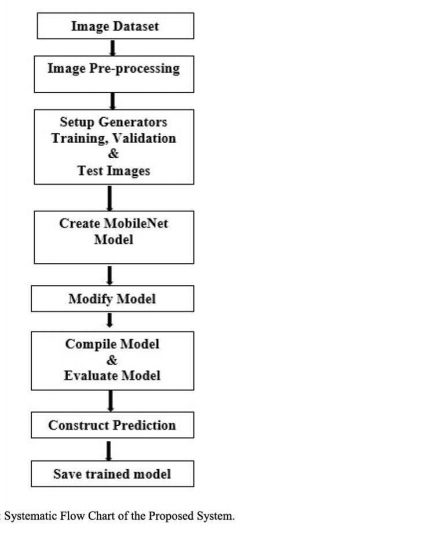

#Import Packages¶


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam , RMSprop
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

#Load Data
The dataset comes from a combination of public accessible
dermatology repositories, color photo atlas of dermatology. The images gathered from online public access dermatology[dermnetnz.org](https://dermnetnz.org). Skin diseases are classified as 23 main classes referring to Dermnet website
but I classify 5 type of Psoriasis Skin diseases and download data in google Drive and used. Data images gathered consist of pusttular, guttate, erythrodermic, inverse, plaqu.

The dataset is partition to train and validation data for each category
of skin disease. The train data consist of 80% of the dataset
while the validatiopn data is 20%-25%.

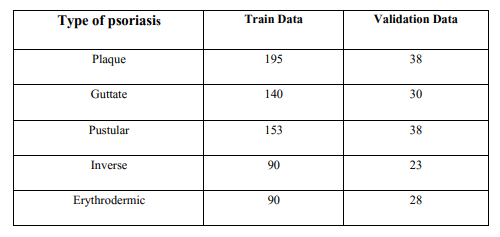

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


#Check Data path


In [ ]:
!ls "/content/drive/My Drive/data"

 fish.zip	       mymodelmobilnet.h5   'psoriasis pic.zip'
 mymodelmobilnet2.h5   mymodelresnet1_5.h5   psoriasis_pic.zip
 mymodelmobilnet3.h5   psoriasis.pdf	     testpic


#Unzipe Data Folder


In [ ]:
import zipfile

local_zip = "/content/drive/My Drive/data/psoriasis_pic.zip"
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/data')
zip_ref.close()

# **Data**

- train: learning the **parameters** of the model.
- valid: learning **hyper-parameters**.

In [ ]:
DATA_DIR = '/data/psoriasis_pic'
os.listdir(DATA_DIR)

['val', 'train']

In [ ]:
train_dir = f'{DATA_DIR}/train'
val_dir = f'{DATA_DIR}/val'
os.listdir(train_dir)

['erythrodermic', 'guttate', 'pusttular', 'plaqu', 'inverse']

#Visualize the data
We can display a random image from the training set.



In [ ]:
import glob

train_fnames = glob.glob(f'{train_dir}/*/*.jpg')
train_fnames[:3]

['/data/psoriasis_pic/train/erythrodermic/erythrokeratodermia-variabilis-4.jpg',
 '/data/psoriasis_pic/train/erythrodermic/pityriasis-rubra-pilaris-41.jpg',
 '/data/psoriasis_pic/train/erythrodermic/pityriasis-rubra-pilaris-69.jpg']

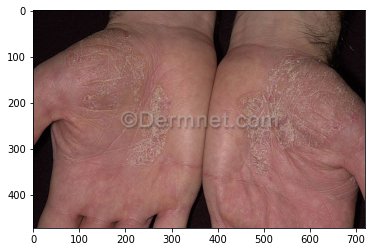

In [ ]:
img = plt.imread(train_fnames[3])
plt.imshow(img);

#**Preprocessing**


*  **Normalization** 

   we'll first scale the data down to a range from 0 to 1.

*  **Data Augmentation**

   Data augmentation occurs when new data is created based on modifications of existing data.For image data specifically, data augmentation could consist of things like flipping the image horizontally or vertically, rotating the image, zooming in or out, cropping, or varying the color, it will help us obtain more data for training.

   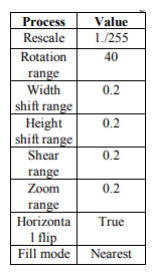




In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen =  ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )


val_datagen =  ImageDataGenerator(
        rescale=1./255
        )



 # **Process The Data**

After our image data is all organized on disk, we need to create the directory iterators for the train, validation, and test sets in the exact same way as we did for the cat and dog data set that we previously used.

 prepare a set of image data for training a CNN.
 Recall that flow_from_directory() just creates batches of the image data to be used for training and validating.

In [ ]:
BATCH_SIZE = 10
HEIGHT = 224
WIDTH = 224
np.random.seed(24)

train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(HEIGHT, WIDTH),
    classes=['inverse', 'pusttular', 'erythrodermic', 'plaqu', 'guttate'],
    class_mode='categorical', 
    batch_size=BATCH_SIZE,
    shuffle=True)

val_generator = val_datagen.flow_from_directory(
    val_dir, 
    target_size=(HEIGHT, WIDTH),
    classes=['inverse', 'pusttular', 'erythrodermic', 'plaqu', 'guttate'],
    class_mode='categorical', 
    batch_size=BATCH_SIZE,
    shuffle=False)

print(train_generator.class_indices)

Found 749 images belonging to 5 classes.
Found 157 images belonging to 5 classes.
{'inverse': 0, 'pusttular': 1, 'erythrodermic': 2, 'plaqu': 3, 'guttate': 4}


In [ ]:
imgs, labels = next(train_generator)



 The data has now been prepared and processed. Next, we'll move on to fine-tuning the model.

#**model**

 MobileNets, pretrain model a class of light weight deep convolutional neural networks that are vastly smaller in size and faster in performance than many other popular models. We’ll also see how we can work with MobileNets in code using TensorFlow's Keras API.

 We first make a call to tf.keras.applications.mobilenet.MobileNet() to obtain a copy of a single pretrained MobileNet with weights that were saved from being trained on ImageNet images. We’re assigning this model to the variable mobile.


In [ ]:
mobile = tf.keras.applications.mobilenet.MobileNet()
mobile.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________

#**Fine-Tuning MobileNet On A Custom Data Set**

 MobileNet combined with the techniques we’ve used for fine-tuning to fine-tune MobileNet for a custom image data set.
 To build the new model, we create an instance of the Model class and specify the inputs to the model to be equal to the input of the original MobileNet, and then we define the outputs of the model to be equal to the output variable we created directly above.

 We still want to keep a lot of what the original MobileNet has already learned from ImageNet by freezing the weights in many of layers, especially earlier ones, but we do indeed need to train some layers since the model still needs to learn features about this new data set.

 So the twenty-third-to-last layer and all layers after it will be trained when we fit the model on the new data set. All layers above will not be trained, so their original ImageNet weights will stay in place.

 Next, we’re going to grab the output from the sixth to last layer of the model and store it in this variable x.We’ll be using this to build a new model. This new model will consist of the original MobileNet up to the sixth to last layer. We’re not including the last five layers of the original MobileNet.

In [ ]:

from keras.layers import Dense, Activation, Flatten, Dropout
from keras.models import Sequential, Model

num_classes=5

def build_finetune_model(finetune_model, dropout, fc_layers, num_classes):

    for layer in mobile.layers[:-23]:
        layer.trainable = False

    x = mobile.layers[-6].output
    x = Flatten()(x)
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x) 
    
    finetune_model = Model(inputs=mobile.input, outputs=predictions)

    return finetune_model

FC_LAYERS = [1024,512]
dropout = 0.3

model = build_finetune_model(mobile, 
                             dropout=dropout, 
                             fc_layers=FC_LAYERS, 
                             num_classes=5)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0   

#Train The Model

Now, we compile the model in the same way as we've done with other models.

Similarly, we call fit() to train the model in the same fashion as we've done for other models.



In [ ]:

from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt


rmsprop = RMSprop(lr=0.0001)
model.compile(rmsprop, loss='categorical_crossentropy', metrics=['accuracy'])



In [ ]:
NUM_EPOCHS = 140
BATCH_SIZE = 10
num_train_images = 749
num_val_images=157

history = model.fit_generator(
    train_generator, epochs=NUM_EPOCHS, workers=16, 
    steps_per_epoch=num_train_images // BATCH_SIZE,  
    validation_data=val_generator,
    validation_steps=num_val_images// BATCH_SIZE,
    verbose=2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/140
74/74 - 9s - loss: 1.8113 - accuracy: 0.2869 - val_loss: 1.2446 - val_accuracy: 0.4800
Epoch 2/140
74/74 - 7s - loss: 1.3882 - accuracy: 0.4709 - val_loss: 1.0790 - val_accuracy: 0.5800
Epoch 3/140
74/74 - 7s - loss: 1.3187 - accuracy: 0.4926 - val_loss: 1.0176 - val_accuracy: 0.5800
Epoch 4/140
74/74 - 7s - loss: 1.1470 - accuracy: 0.5359 - val_loss: 0.9324 - val_accuracy: 0.6200
Epoch 5/140
74/74 - 7s - loss: 1.0999 - accuracy: 0.5913 - val_loss: 0.8734 - val_accuracy: 0.6800
Epoch 6/140
74/74 - 7s - loss: 1.0407 - accuracy: 0.6143 - val_loss: 0.8517 - val_accuracy: 0.6733
Epoch 7/140
74/74 - 7s - loss: 1.0359 - accuracy: 0.5900 - val_loss: 0.8137 - val_accuracy: 0.7133
Epoch 8/140
74/74 - 7s - loss: 0.9657 - accuracy: 0.6319 - val_loss: 0.7655 - val_accuracy: 0.7267
Epoch 9/140
74/74 - 7s - loss: 0.9515 - accuracy: 0.6414 - val_loss: 0.7373 - val_accuracy: 0.7333
Epoch 10/140
74/74 - 7s - loss: 0.8500 - accuracy: 0.6806 - val_loss: 0.7468 - val_accuracy: 0.7267
Epoch 11/

# Plot training and validation accuracy & loss per epoch

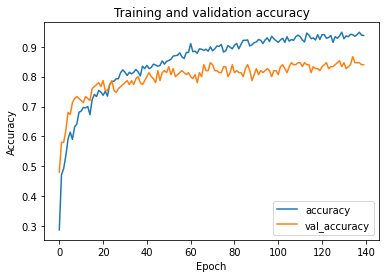

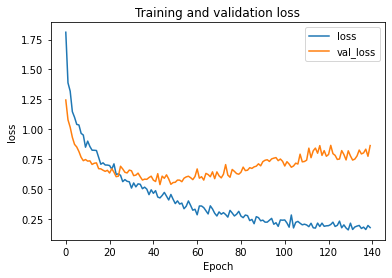

In [ ]:
# Plot training and validation accuracy per epoch
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend(loc='lower right')
plt.figure()

# Plot training and validation loss per epoch
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('loss')

plt.legend(loc='upper right')

#Evaluate Model

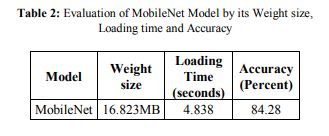

In [ ]:
test_pred = model.evaluate(val_generator)

16/16 [==============================] - 1s 72ms/step - loss: 0.8456 - accuracy: 0.8408


#plot_confusion_matrix

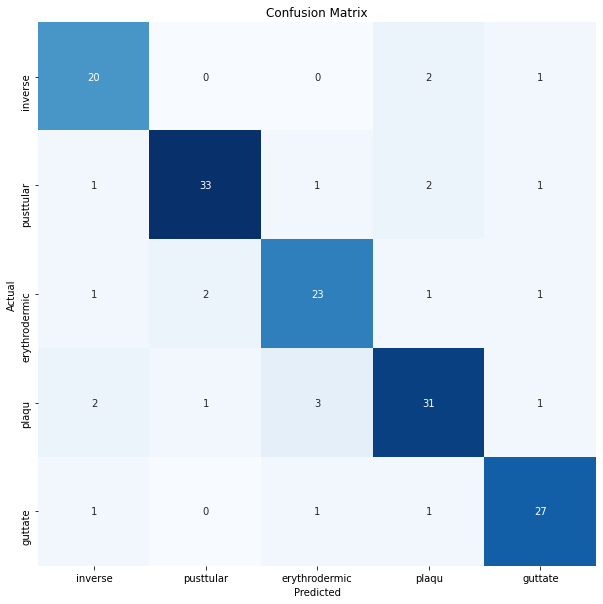

In [ ]:
import seaborn as sns
from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

label_mapping ={0:'inverse', 1:'pusttular', 2:'erythrodermic', 3:'plaqu', 4:'guttate'}

y_true = np.array(val_generator.classes)

y_pred = model.predict(x=val_generator)
y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=False, cmap='Blues')

plt.xticks(np.arange(5) + 0.5, label_mapping.values())
plt.xlabel("Predicted")

plt.yticks(np.arange(5) + 0.5, label_mapping.values())
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()

#Report classification

In [ ]:
clr = classification_report(y_true, y_pred,  target_names=label_mapping.values())
print(clr)

               precision    recall  f1-score   support

      inverse       0.80      0.87      0.83        23
    pusttular       0.92      0.87      0.89        38
erythrodermic       0.82      0.82      0.82        28
        plaqu       0.84      0.82      0.83        38
      guttate       0.87      0.90      0.89        30

     accuracy                           0.85       157
    macro avg       0.85      0.86      0.85       157
 weighted avg       0.85      0.85      0.85       157



#Save model to disk
After training the model, the model weight and architecture
can be saved with .h5 file extension which is a Keras file. To
properly deploy the CNN model to an Android application the
.h5 file should be converted to a protobuff file with a file
extension.

In [ ]:
model.save("/content/drive/My Drive/data/mymodelmobilnet3.h5")
print("Saved model to disk")

Saved model to disk
